In [3]:
import pandas as pd
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
from collections import OrderedDict, defaultdict

import cvxpy as cp

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 04 10:42:42 PM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 04 10:42:42 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


In [4]:
import numpy as np

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [5]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 946702800, endDate = 1641013200
- BRK.B: No data found, symbol may be delisted


In [6]:
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)

## Testing Initial Portfolio without Bayes

In [7]:
five_year_data=SP_Close[:1265] #5 years of data

In [8]:
from pypfopt.efficient_frontier import EfficientFrontier

mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(ef.portfolio_performance(verbose=True))

Expected annual return: 44.8%
Annual volatility: 13.6%
Sharpe Ratio: 3.15
(0.44813887438461064, 0.1359156382279738, 3.1500339472819556)


## Look at some correlations and clustering to gather ideas

In [9]:
corr = five_year_data.corr()
#plt.figure(figsize=(12,8))
#sns.clustermap(corr)

In [10]:
import scipy.cluster.hierarchy as shc
#dimensions = SP_Close.shape[1]
#plt.figure(figsize=(10, 7))  
#plt.title("Dendrograms")  
#dend = shc.dendrogram(shc.linkage(corr, method='ward'))

## Clustering algorithm using rule: select minimum number of clusters such that at most stock_pct_thresh of stocks are in clusters with an internal corr of corr_thresh

In [14]:
from sklearn.cluster import AgglomerativeClustering
#rule is to select number of clusters clusters such that at most stock_pct_thresh of stocks are in clusters 
#with an internal corr of corr_thresh

def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

def constrained_clusters(corr, corr_thresh = .7, stock_pct_thresh = .1):
    ix = -1 #start at highest threshold and move backward
    threshes = np.exp(np.arange(0,5,.05))#need a better system for this to make it not dependant on number of assets, 

    for i in range(len(threshes)):
        thresh = threshes[ix]
        stock_clusters = get_clusters(corr, Thresh = thresh)
        cluster_number = stock_clusters['cluster'].max()+1

        internal_corr_average = np.zeros([cluster_number])
        for n in range(cluster_number):
            cluster_corr = corr.loc[stock_clusters.loc[stock_clusters['cluster']==n].index,stock_clusters.loc[stock_clusters['cluster']==n].index]
            internal_corr_average[n] = cluster_corr.mean().mean()

        clustersWInternalCorrLessThanThreshold = np.argwhere(internal_corr_average<corr_thresh).flatten()
        percent_stocks_in_bad_clusters = len(stock_clusters.loc[stock_clusters['cluster'].isin(clustersWInternalCorrLessThanThreshold)])/len(stock_clusters)
        if percent_stocks_in_bad_clusters > stock_pct_thresh:
            ix-=1
        else:
            break
    print("# of clusters:", cluster_number)
    print("percent of stocks in clusters with internal corr of less than corr_thresh:", percent_stocks_in_bad_clusters)

    #run clustering with chosen optimal method
    return get_clusters(corr, cluster_number = cluster_number)


#test cluster corr

#temp = plt.hist(internal_corr_average,bins=15)
#plt.title("hist of ave of internal correlation matrices")
#plt.show()

## backtest

In [15]:
def calculate_posterior_mean(like_pop, prior_pop):
    mu0 = prior_pop.mean()
    w0 = prior_pop.std()
    dbar = like_pop.mean()
    w = like_pop.std()
    # Prior:
    prior = stats.norm(mu0, w0)
    # Likelihood:
    like = stats.norm(dbar, w)
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s

#calculated expected return array
def likelihood_n_posterior_mus(n, data, period=16): #period of 16 is 3 months with weekly data
    like_mus = np.zeros(len(data.columns))
    post_mus = np.zeros(len(data.columns))
    for ints,sector in enumerate(data
                                 .columns): 
        likelihood_pop = np.array(data.iloc[n-period : n - 1][sector])
        prior_pop = np.array(data.iloc[n-period : n - 1])
        like_mus[ints] = likelihood_pop.mean() #normal mean opt 
        post_mus[ints] = calculate_posterior_mean(likelihood_pop,prior_pop) #bayesian means 
    return like_mus, post_mus

## Markowitz Rebalancer

In [16]:
clusters = constrained_clusters(corr,)
#get_clusters(corr, cluster_number = 46)

# of clusters: 44
percent of stocks in clusters with internal corr of less than corr_thresh: 0.08174386920980926


In [54]:
#clusters.loc[clusters['cluster']==0].index

In [53]:
#five_year_data[clusters.loc[clusters['cluster']==0].index].head()
#mu is a series with the index being the company name alphabetically

In [21]:
def Markowits_Bayes_Rebalance(securities_vector, 
                              rebalance_period,
                              prior_period,
                              update_period=0,
                              verbose=True,
                              weight_bounds=(-1,1), 
                              mean_shrink = False, 
                              corr_shrink = True):
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list, asset_return_list, dates=[], [], [] #create lists
    
    for p in range(0,len(securities_vector)-prior_period-rebalance_period,rebalance_period): #len(securities_vector)-prior_period-rebalance_period,rebalance_period
        prior_vector = securities_vector[p:prior_period+p]
        
        #if p == 0:
        #    clusters = constrained_clusters(prior_vector.corr(), corr_thresh = .7, stock_pct_thresh = .1)
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
        if mean_shrink == True:
            pass #Bayesian update not yet implemented
        else:   
            mu = mean_historical_return(prior_vector)
            
        if corr_shrink == True:
            S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        else:
            S = sample_cov(prior_vector)                          #is this right?
            
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        #tainon's code, returns from now to next rebalance
        log_price_df = np.log(securities_vector.iloc[prior_period+p:prior_period+p+(max(rebalance_period-1,1))+1:(max(rebalance_period-1,1))])
        
        returns = (log_price_df.subtract(log_price_df.iloc[1]).iloc[0]*-1).to_dict(OrderedDict)
        asset_return_list.append(returns)
        dates.append(prior_vector.index[-1])
        
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates
    asset_returns_df = pd.DataFrame(asset_return_list)
    asset_returns_df.index = dates
    return weight_df,asset_returns_df

In [22]:
monthly_vanilla_markowitz_weights,returns = Markowits_Bayes_Rebalance(SP_Close,21,252*5,verbose=False) #monthly rebalance with 5 year matrix

In [24]:
#port returns
port_returns = np.sum(monthly_vanilla_markowitz_weights*returns, axis=1)

In [30]:
#growth of 1 dollar invested
def dollar_growth(returns):
    return ((returns+1).cumprod())

In [51]:
port_returns[30:40]

2007-07-11   -0.132168
2007-08-09    0.137760
2007-09-10    0.713917
2007-10-09    0.215510
2007-11-07    0.217978
2007-12-07    0.648322
2008-01-09   -0.981183
2008-02-08   -0.503108
2008-03-11   -0.125162
2008-04-10   -0.021015
dtype: float64

<AxesSubplot:>

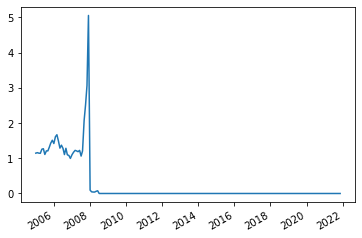

In [52]:
dollar_growth(port_returns).plot()

In [ ]:
#question: update clusters at each rebalance?
#need to fix. my algorithm assumes a solution is feasible, need a better system for choosing thresholds
#45 clusters for each rebalance
#shrinkage works on returns markowitz works on price series


